<a href="https://colab.research.google.com/github/yuvi-s64/YuviN-DataScience-GenAI-Submissions/blob/main/6_03_ML_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

#6.03 ML in Practice
This Notebook is designed to help you think about working through an ML project in real-world, and, in particular, interpreting the results when the go wrong. We will look at _under-_ and _over-fitting_, as well as imbalance classes in classification.

## Under- and Over-Fitting
The first case is really classical machine learning in a nutshell. Trying to get the right balance between bias and variance. We know the tools we have (algorithm choice and hyperparameters), but how do we diagnose these problems? Will have a look at an example problem to help understand this.

First, we'll import the packages we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_classification # generate synthetic data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay as CM, f1_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

# Make sure you have run: pip install imbalanced-learn if not using Colab
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Special pipeline for samplers

# Set random seed for reproducibility
np.random.seed(42)

Most of these we've seen, those that you haven't we'll explain as we go along. We'll start with `make_moons` which is used to create synthetic data for classification:

In [2]:
# Generate 200 samples with some random error (noise)
X, y = make_moons(n_samples=200, noise=0.35, random_state=1984)

# Split into training (50%) and testing (50%) sets - just for illustration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Visualisation Setup
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Red/Blue for points

Here we have made data (`X` is the features and `y` the labels). We have created 200 samples (i.e. rows) with a noise level of 35%. This means that 35% of the variation in the data comes from random error ... which is reasonably typical of the real world. We have set the `random_state` as a fixed number (1984 - the year my wife was born) so that we get the same results each time.

We've then split into training and test - using an usually high split of 50% for test just because it will help us visualise and understand the outputs a bit better (its not a real model after all).

Now we have a long loop to build models and visualisations. Don't worry too much about this, its an artificial case for learning not something we would do in practice, but I'll summarise the main parts.

* We set up three possible `max_depth` values we will build from. 1 is a very shallow, single-line tree that will underfit. _None_ means no restriction so will likely overfit. 4 should be about ideal fitting for the data.
* We loop through these in the line `for i, depth in enumerate(max_depths):` at each stage training the model with each `max_depth` value and then visualising the decision boundary and reporting the metrics.
* `DecisionBoundryDisplay` is a scikit-learn function to show the lines created by the decision tree each time.

Don't worry too much about the rest!

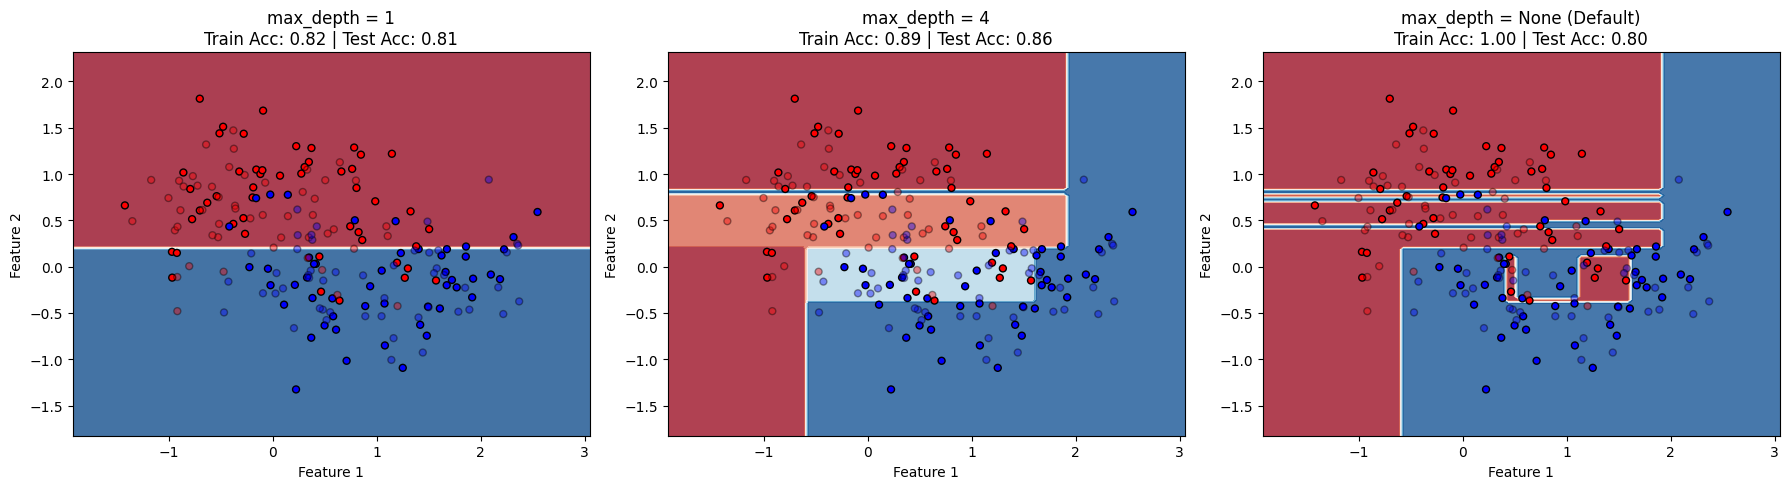

In [3]:
# Define the depths for our models
max_depths = [1, 4, None]

# Create a figure to plot the results
plt.figure(figsize=(18, 5))

# Loop through each max_depth value
for i, depth in enumerate(max_depths):
    ax = plt.subplot(1, len(max_depths), i + 1)

    # Create and train the Decision Tree classifier
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    # Calculate accuracy on train and test sets
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    # Use a display-friendly label for max_depth=None
    depth_label = "None (Default)" if depth is None else depth

    # --- Plotting ---

    # Plot the decision boundary
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        cmap=plt.cm.RdBu,
        alpha=0.8,
        ax=ax,
        eps=0.5
    )

    # Plot the training points (solid)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolor='k', s=25)
    # Plot the test points (semi-transparent)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.4, edgecolor='k', s=25)

    # Add labels and title
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(f"max_depth = {depth_label}\nTrain Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f}")


plt.tight_layout()
plt.show()


As expected, the first tree (left) is too simple (underfitting). We can see just the single line basically in the middle. The accuracy in training is 82%, which is basically the same as test accuracy (81%). This can be a sign of underfitting aswell (if test score is roughly equal or even better than training score).

The last tree (right) has overfit and is too complex. The visualisation shows lots of blue lines cutting through the red blocks, and red shapes within the blue block. These are risky ... they may well be there because of random variation. More damning though are the statistics. 100% accuracy in training is often worrying on its own ... a generalised model will most likely get some predictions wrong because of random error. However, the bigger concern is the significant drop in test accuracy - from 100% down to 80%. This is clearly overfitting, we have fit too tightly to random error in training to get 100% and some of those patterns are not present in the test.

Our Goldilocks option in the middle (`max_trees`=4) is more complex than the first, but not overly complex like the last. We can see a more modest 89% training accuracy, and, more importantly, the drop to 86% (so 3% drop) is about what we expect to see for a well fitted model.  


## Class Imbalance
Next we will build a different dataset to highlight the challenges of imbalance in classification. We will make the data 99% class 0 and 1% class 1. It will have 5 useful features, and none that are completely redundant.

We will split into a more traditional 70% training / 30% testing, making sure to stratify by y-value so there are proportionally the same number of classes 1's in both training and testing data.

We have decided that the metric we will care most about is the macro F1 score. This is an arbitrary choice ... in the real world we base this choice on the business case and nature of the problem (which we don't know here).

Next we will build a baseline model (no measures to combat imbalance) using logistic regression. We will inspect the model using scikit-learn's `classification_report` (which is new, but basically is used to summarise the common metrics like precision, recall and F1 which we have seen) and a confusion matrix:

Training set: [6894  106]
Test set: [2955   45]


Baseline Model (Naive)
Baseline Classification Report:
               precision    recall  f1-score   support

Class 0 (Maj)       0.99      1.00      0.99      2955
Class 1 (Min)       1.00      0.02      0.04        45

     accuracy                           0.99      3000
    macro avg       0.99      0.51      0.52      3000
 weighted avg       0.99      0.99      0.98      3000





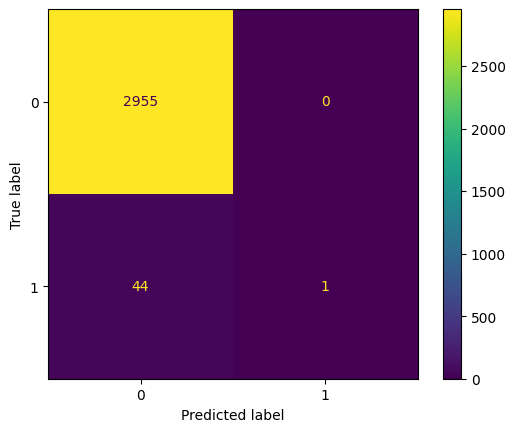

In [4]:
# Create a 99% / 1% imbalanced dataset
X, y = make_classification(n_samples=10000,
                           n_features=10, # total features
                           n_informative=5, # useful features
                           n_redundant=0, # completely redundant features
                           n_classes=2,
                           weights=[0.99, 0.01], # 99% class 0, 1% class 1
                           random_state=42)

# Split into 70% train and 30% test using 'stratify=y' to maintain the imbalance in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the distribution
print(f"Training set: {np.bincount(y_train)}")
print(f"Test set: {np.bincount(y_test)}")

# --- 1. Baseline Model (Naive) ---
print("\n")
print("Baseline Model (Naive)")

# Train a standard Logistic Regression
baseline_algo = LogisticRegression(random_state=42)
baseline_model = baseline_algo.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=["Class 0 (Maj)", "Class 1 (Min)"]))
print("\n")

# Plot Confusion Matrix
CM.from_predictions(y_test, y_pred_baseline)

We can see the model is very biased towards class 0. In fact, it only predicts 1 a single time (albeit correctly). Whilst our overall accuracy is 99%, this just reflects that so much of the data is class 0. We should not be fooled by this!!!!

We can see that the metric we care most about, _macro F1_ is down at 52% ... not great. Even worse we can see that class 1 has very low scores for both _recall_ (2%) and _F1_ (4%), although precision is 100% (it makes a single prediction of class 1 and gets it right).

This is not a good model. Let's try and tweak it. First we will adjust the `class_weight` of the algorithm. This means we will add extra weight in training to samples that are class 1. I.e., if we misclassify a class 1 sample the algorithm will give extra weight to this than a misclassified class 0 when adjusting the model weights (basically the same thing we saw with GBDT). Let's see how this does:

Model with class_weight='balanced'
Class-Weighted Model Classification Report:
               precision    recall  f1-score   support

Class 0 (Maj)       0.99      0.66      0.79      2955
Class 1 (Min)       0.03      0.60      0.05        45

     accuracy                           0.66      3000
    macro avg       0.51      0.63      0.42      3000
 weighted avg       0.98      0.66      0.78      3000





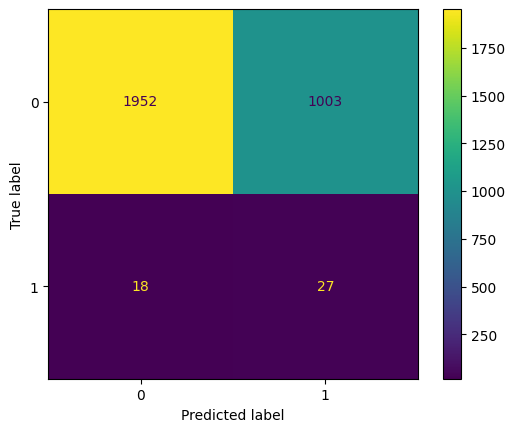

In [5]:
print("Model with class_weight='balanced'")

# 'balanced' mode automatically creates weights to penalize minority class errors
model_weighted = LogisticRegression(random_state=42, class_weight='balanced')
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)

print("Class-Weighted Model Classification Report:")
print(classification_report(y_test, y_pred_weighted, target_names=["Class 0 (Maj)", "Class 1 (Min)"]))
print("\n")

# Plot Confusion Matrix
CM.from_predictions(y_test, y_pred_weighted)

Our model is now encourage to make many more class 1 predictions. We have gone from 1 in total to 1030 (although only 27 of these are correct). This has the effect of increasing _recall_ for class 0 to 60% (from 2%), but at the cost of class 0 _precision_ (which goes from 100% down to 3%). The class 0 _F1_ is only slightly improved at 5% (from 4%). Overall _macro F1_, the main metric we care about, has decreased from 52% to 42%.  

Overall then, we have to include this hasn't helped. Let's try another approach ... biasing the prediction threshold. Normally our classifier will predict any outcome where the probability $>= 0.5$ as class 1, and everything else class 0 (i.e. if the model thinks there is a 50% or more chance that this is class 1 we predict class 1 ... quite logically). However, instead we will (arbitarily) change this to 0.1 ... i.e. if the model thinks there is a 10% chance or more of class 1 it predicts class 1. Let's see how it does:

Biasing the Prediction Threshold
Classification Report with Threshold = 0.1:
               precision    recall  f1-score   support

Class 0 (Maj)       0.99      1.00      0.99      2955
Class 1 (Min)       0.21      0.07      0.10        45

     accuracy                           0.98      3000
    macro avg       0.60      0.53      0.55      3000
 weighted avg       0.97      0.98      0.98      3000





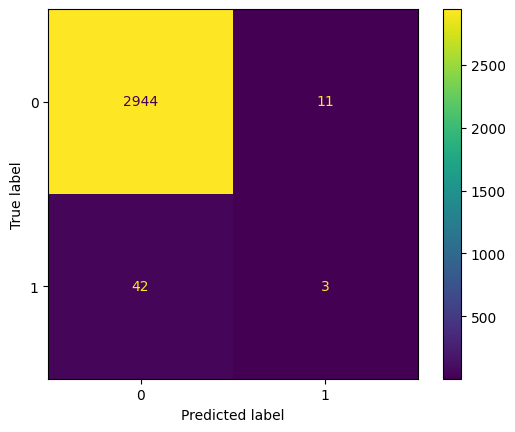

In [6]:
print("Biasing the Prediction Threshold")

# Get predicted probabilities for Class 1 from the *baseline* model
# Note we don't need to retrain anything ... we are just using the previous prediction probabilities
y_probs = baseline_model.predict_proba(X_test)[:, 1]

# Set a new, lower threshold
new_threshold = 0.1 # This value is arbitrary; in practice, you'd tune it

# Classify based on the new threshold
y_pred_threshold = (y_probs >= new_threshold).astype(int)

print(f"Classification Report with Threshold = {new_threshold}:")
print(classification_report(y_test, y_pred_threshold, target_names=["Class 0 (Maj)", "Class 1 (Min)"]))
print("\n")

# Plot Confusion Matrix
CM.from_predictions(y_test, y_pred_threshold)

The effect here is a little different. We have now more class 1 predictions than the baseline model (previously just 1 ... now we have 14). Most of our metrics are a little bit better than baseline:
* Class 0 _recall_ at 7%
* Class 0 _F1_ at 10%
* Class 0 _precision_ at 21% (this has dropped but is better)
* _Macro F1_ at 55%.

Better but not great. The model still predicts too few class 1's. Instead we will try another technique ... undersampling. This means that rather using all 2955 examples of class 0, we will sample (in a needlessly aggressive way) only as many samples as we have of class 1 (45 total). This means we learn a model with 45 class 0 samples and 45 class 1 samples.

Note we sample during the training (fit) of the model not before training and test split to avoid adjusting the test data.

Undersampling (RandomUnderSampler)
Undersampled Model Classification Report:
               precision    recall  f1-score   support

Class 0 (Maj)       0.99      0.64      0.78      2955
Class 1 (Min)       0.03      0.73      0.06        45

     accuracy                           0.64      3000
    macro avg       0.51      0.69      0.42      3000
 weighted avg       0.98      0.64      0.77      3000





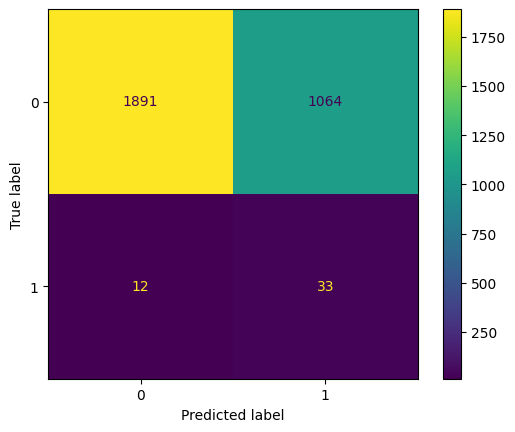

In [7]:
print("Undersampling (RandomUnderSampler)")

# We use ImbPipeline to correctly apply the sampler ONLY during .fit()
# This prevents data leakage and applies the sampler to the training data in each CV fold
# For this simple demo, we define the steps
rus = RandomUnderSampler(random_state=42)
model_rus = LogisticRegression(random_state=42)

# Create and fit the pipeline
# NOTE: We fit on X_train, y_train. The sampler is applied internally.
pipeline_rus = ImbPipeline([('sampler', rus), ('model', model_rus)])
pipeline_rus.fit(X_train, y_train)

# Predict on the *original* test set
y_pred_rus = pipeline_rus.predict(X_test)

print("Undersampled Model Classification Report:")
print(classification_report(y_test, y_pred_rus, target_names=["Class 0 (Maj)", "Class 1 (Min)"]))
print("\n")

# Plot Confusion Matrix
CM.from_predictions(y_test, y_pred_rus)

Again we now have lots of class 1 predictions ... way too many in fact. This means we improve class 0 recall at the cost of precision again. The numbers are:
* Class 0 _recall_ at 73%
* Class 0 _F1_ at 6%
* Class 0 _precision_ at 3% (this has dropped but is better)
* _Macro F1_ at 42%.

Our key metric (_macro F1_) is again lower and baseline so this is not a good model. Interpreting this is an interesting case. We have _underfit_ the model by _overfitting_ the data. We are underfitting because there is significant bias in the model ... due to having too little data to learn the real, complex pattern. However, this is caused by overfitting to random error in the small dataset.

Intersting analysis aside, its a problem. In the real-world we would probably not reduce class 0 to be 50/50 with class 1, but this is not the real world this is me messing around.

This leads us to our last attempt then, oversampling. Instead of reducing class 0 we will create synthetic examples of class 1 using the [SMOTE](https://arxiv.org/abs/1106.1813) algorthim. Again we will create a lot of samples, enough to match with class 0. In practice we may not need to go quite this far, but its messing around remember.

Oversampling (SMOTE)
SMOTE Model Classification Report:
               precision    recall  f1-score   support

Class 0 (Maj)       0.99      0.67      0.80      2955
Class 1 (Min)       0.03      0.62      0.05        45

     accuracy                           0.67      3000
    macro avg       0.51      0.65      0.43      3000
 weighted avg       0.98      0.67      0.79      3000





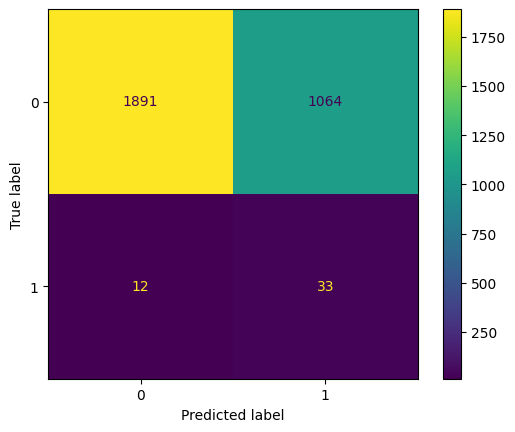

In [8]:
print("Oversampling (SMOTE)")

# Define the SMOTE sampler and the model
smote = SMOTE(random_state=42)
model_smote = LogisticRegression(random_state=42)

# Create and fit the pipeline
pipeline_smote = ImbPipeline([('sampler', smote), ('model', model_smote)])
pipeline_smote.fit(X_train, y_train)

# Predict on the *original* test set
y_pred_smote = pipeline_smote.predict(X_test)

print("SMOTE Model Classification Report:")
print(classification_report(y_test, y_pred_smote, target_names=["Class 0 (Maj)", "Class 1 (Min)"]))

print("\n")

# Plot Confusion Matrix
CM.from_predictions(y_test, y_pred_rus)

This behaves similarly to many of our other examples, dramatically increasing class 1 predictions but at the cost of overall performance:
* Class 0 _recall_ at 62%
* Class 0 _F1_ at 5%
* Class 0 _precision_ at 3% (this has dropped but is better)
* _Macro F1_ at 43%.

Overall we can see that in these cases ... it's just hard. Nothing has __"fixed"__ our problem, just tweaked things in different ways. Given different data, different modifications to the approaches, and certainly different class imbalance, you may get better results, but there are no silver bullets!